# Natural Language Processing - Text Summarization example

### 0 - Setup

Install Packages 

In [2]:
!pip install transformers==3.0.1
!pip install nlp_utils
!pip install datasets
!pip install lime
!pip install shap
!pip install langdetect
!pip install rouge
!pip install contractions

     |████████████████████████████████| 112 kB 5.0 MB/s 
     |████████████████████████████████| 325 kB 5.1 MB/s 
     |████████████████████████████████| 77 kB 8.3 MB/s 
     |████████████████████████████████| 136 kB 57.4 MB/s 
     |████████████████████████████████| 212 kB 51.7 MB/s 
     |████████████████████████████████| 1.1 MB 61.1 MB/s 
     |████████████████████████████████| 127 kB 76.4 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 144 kB 63.7 MB/s 
     |████████████████████████████████| 271 kB 74.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [6]:
import datasets
dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')

lst_dics = [dic for dic in dataset["train"]]
dtf = pd.DataFrame(lst_dics).rename(columns={"article":"text", "highlights":"y"})[["text","y"]].head(20000)
dtf.to_csv("data_summary.csv", index=False)
dtf.head()

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


  0%|          | 0/3 [00:00<?, ?it/s]

,text,y
0,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...
1,(CNN) -- Usain Bolt rounded off the world cham...,Usain Bolt wins third gold of world championsh...
2,"Kansas City, Missouri (CNN) -- The General Ser...",The employee in agency's Kansas City office is...
3,Los Angeles (CNN) -- A medical doctor in Vanco...,NEW: A Canadian doctor says she was part of a ...
4,(CNN) -- Police arrested another teen Thursday...,Another arrest made in gang rape outside Calif...


In [7]:
dtf = pd.read_csv("data_summary.csv")
dtf.head()

,text,y
0,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...
1,(CNN) -- Usain Bolt rounded off the world cham...,Usain Bolt wins third gold of world championsh...
2,"Kansas City, Missouri (CNN) -- The General Ser...",The employee in agency's Kansas City office is...
3,Los Angeles (CNN) -- A medical doctor in Vanco...,NEW: A Canadian doctor says she was part of a ...
4,(CNN) -- Police arrested another teen Thursday...,Another arrest made in gang rape outside Calif...


In [8]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   y       20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [9]:
# check
i = 4
print("--- Full text ---")
print(dtf["text"][i])
print(" ")
print("--- Summary ---")
print(dtf["y"][i])

--- Full text ---
(CNN) -- Police arrested another teen Thursday, the sixth suspect jailed in connection with the gang rape of a 15-year-old girl on a northern California high school campus. Jose Carlos Montano, 18, was arrested on charges of felony rape, rape in concert with force, and penetration with a foreign object, said Richmond Police Lt. Mark Gagan. Montano was arrested Thursday evening in San Pablo, California, a small town about two miles from the city of Richmond, where the crime took place. Montano, who was held in lieu of $1.3 million bail, is accused of taking part in what police said was a 2½-hour assault on the Richmond High School campus. Police said as many as 10 people were involved in the rape in a dimly lit back alley at the school, while another 10 people watched without calling 911. The victim was taken to the hospital in critical condition, but was released Wednesday. Four other teenage suspects were arraigned Thursday on charges connected to the rape. Cody Ray 

### Get Helper functions

In [3]:
!wget https://raw.githubusercontent.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/master/natural_language_processing/nlp_utils.py

--2022-04-16 17:23:47--  https://raw.githubusercontent.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/master/natural_language_processing/nlp_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80522 (79K) [text/plain]
Saving to: ‘nlp_utils.py.1’

nlp_utils.py.1      100%[===================>]  78.63K  --.-KB/s    in 0.01s   

2022-04-16 17:23:47 (5.92 MB/s) - ‘nlp_utils.py.1’ saved [80522/80522]



In [4]:
from nlp_utils import *

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
def evaluate_summary(y_test, predicted):
    rouge_score = rouge.Rouge()
    scores = rouge_score.get_scores(y_test, predicted, avg=True)
    score_1 = round(scores['rouge-1']['f'], 2)
    score_2 = round(scores['rouge-2']['f'], 2)
    score_L = round(scores['rouge-l']['f'], 2)    
    return round(np.mean([score_1,score_2,score_L]), 2)

### 1 - Text Analysis

- Text cleaning
- Word frequency
- Length analysis

###### Text cleaning

In [10]:
# Importing & Downloading required libraries
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
lst_stopwords = create_stopwords()
lst_stopwords = lst_stopwords + ["new","ha","cnn","said","say","wa"]

In [12]:
dtf = add_preprocessed_text(dtf, column="text", 
                            punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, lemm=True)
dtf = add_preprocessed_text(dtf, column="y", 
                            punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, lemm=True)
dtf.head()

,text,y,text_clean,y_clean
0,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...,official president barack obama want lawmaker ...,syrian official obama climbed top tree doe kno...
1,(CNN) -- Usain Bolt rounded off the world cham...,Usain Bolt wins third gold of world championsh...,usain bolt rounded world championship sunday c...,usain bolt win third gold world championship a...
2,"Kansas City, Missouri (CNN) -- The General Ser...",The employee in agency's Kansas City office is...,kansa city missouri general service administra...,employee agency kansa city office among hundre...
3,Los Angeles (CNN) -- A medical doctor in Vanco...,NEW: A Canadian doctor says she was part of a ...,los angeles medical doctor vancouver british c...,canadian doctor part team examining harry burk...
4,(CNN) -- Police arrested another teen Thursday...,Another arrest made in gang rape outside Calif...,police arrested another teen thursday sixth su...,another arrest made gang rape outside californ...


In [13]:
# Checking the output
print("--- Full text ---")
print(dtf["text_clean"][i])
print(" ")
print("--- Summary ---")
print(dtf["y_clean"][i])

--- Full text ---
police arrested another teen thursday sixth suspect jailed connection gang rape 15yearold girl northern california high school campus jose carlos montano 18 arrested charge felony rape rape concert force penetration foreign object richmond police lt mark gagan montano arrested thursday evening san pablo california small town two mile city richmond crime took place montano held lieu 13 million bail accused taking part police 2½hour assault richmond high school campus police many 10 people involved rape dimly lit back alley school another 10 people watched without calling 911 victim taken hospital critical condition released wednesday four teenage suspect arraigned thursday charge connected rape cody ray smith described court older 14 pleaded guilty charge rape foreign object rape force two juvenile ari abdallah morale marcelles james peter appeared smith contra costa county superior court enter plea court described morale younger 16 give age peter three juvenile wore b

###### Word frequency

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


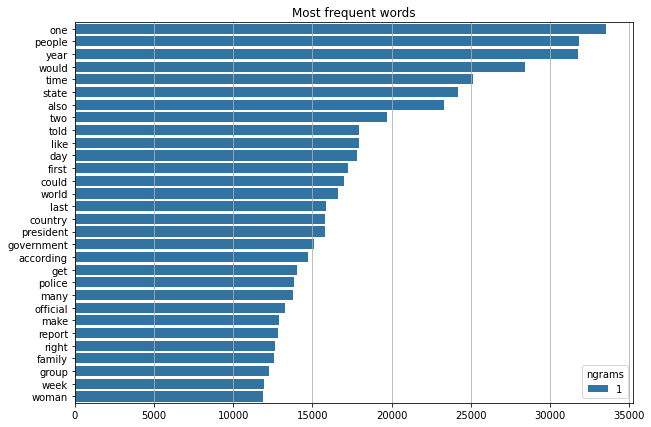

In [13]:
# Find most common words in text
dtf_freq = word_freq(corpus=dtf["text_clean"], ngrams=[1], top=30, figsize=(10,7))

In [14]:
thres = 5
X_top_words = len(dtf_freq[dtf_freq["freq"]>thres])
X_top_words

43001

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


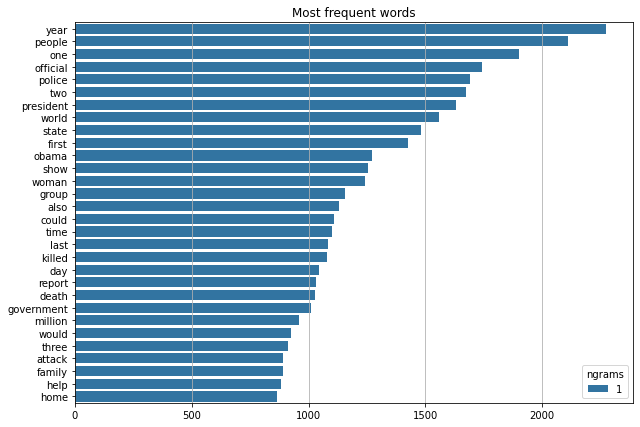

In [15]:
# Find most common words in summaries
dtf_freq = word_freq(corpus=dtf["y_clean"], ngrams=[1], top=30, figsize=(10,7))

In [16]:
thres = 5
y_top_words = len(dtf_freq[dtf_freq["freq"]>thres])
y_top_words

10245

###### Length analysis

In [17]:
# Texts
X = add_text_length(dtf, "text_clean")

                            min         mean          max
char_count           103.000000  2260.111050  10038.00000
word_count            19.000000   363.757250   1309.00000
sentence_count         1.000000     1.000000      1.00000
avg_word_length        3.992945     6.210498     35.34507
avg_sentence_lenght   19.000000   363.757250   1309.00000


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


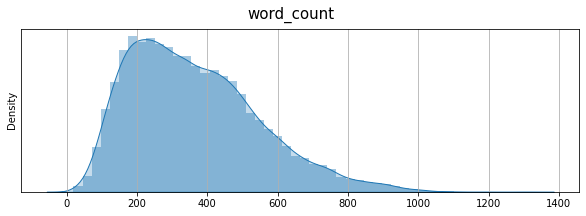

In [18]:
plot_distributions(X, x="word_count", figsize=(10,3))

In [40]:
X_len = 400

In [41]:
# Summaries
y = add_text_length(dtf, "y_clean")

                       min        mean    max
char_count           35.00  164.703200  319.0
word_count            4.00   27.015550   50.0
sentence_count        1.00    1.000000    1.0
avg_word_length       4.15    6.117206   10.0
avg_sentence_lenght   4.00   27.015550   50.0


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


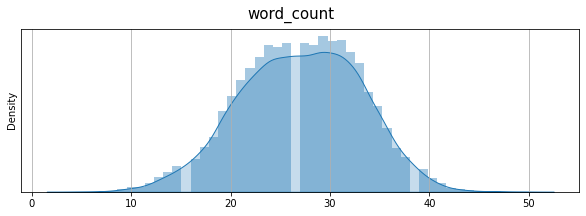

In [21]:
plot_distributions(y, x="word_count", max_cat=1, figsize=(10,3))

In [16]:
y_len = 40

###### Summary

In [23]:
dtf = dtf[["text","text_clean","y","y_clean"]]
dtf.head()

,text,text_clean,y,y_clean
0,It's official: U.S. President Barack Obama wan...,official president barack obama want lawmaker ...,Syrian official: Obama climbed to the top of t...,syrian official obama climbed top tree doe kno...
1,(CNN) -- Usain Bolt rounded off the world cham...,usain bolt rounded world championship sunday c...,Usain Bolt wins third gold of world championsh...,usain bolt win third gold world championship a...
2,"Kansas City, Missouri (CNN) -- The General Ser...",kansa city missouri general service administra...,The employee in agency's Kansas City office is...,employee agency kansa city office among hundre...
3,Los Angeles (CNN) -- A medical doctor in Vanco...,los angeles medical doctor vancouver british c...,NEW: A Canadian doctor says she was part of a ...,canadian doctor part team examining harry burk...
4,(CNN) -- Police arrested another teen Thursday...,police arrested another teen thursday sixth su...,Another arrest made in gang rape outside Calif...,another arrest made gang rape outside californ...


### 2 - Preprocessing

In [14]:
# Partitioning
dtf_train = dtf.iloc[i+1:]
dtf_test = dtf.iloc[:i+1]
dtf_test

,text,y,text_clean,y_clean
0,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...,official president barack obama want lawmaker ...,syrian official obama climbed top tree doe kno...
1,(CNN) -- Usain Bolt rounded off the world cham...,Usain Bolt wins third gold of world championsh...,usain bolt rounded world championship sunday c...,usain bolt win third gold world championship a...
2,"Kansas City, Missouri (CNN) -- The General Ser...",The employee in agency's Kansas City office is...,kansa city missouri general service administra...,employee agency kansa city office among hundre...
3,Los Angeles (CNN) -- A medical doctor in Vanco...,NEW: A Canadian doctor says she was part of a ...,los angeles medical doctor vancouver british c...,canadian doctor part team examining harry burk...
4,(CNN) -- Police arrested another teen Thursday...,Another arrest made in gang rape outside Calif...,police arrested another teen thursday sixth su...,another arrest made gang rape outside californ...


### 3 - Baseline (Extractive: TextRank)

In [42]:
# Test (no Train)
predicted = textrank(corpus=dtf_test["text"], ratio=y_len/X_len)

In [43]:
# Evaluate
score = 0.0
for i in range(dtf_test["y"].size):
  score += evaluate_summary(dtf_test["y"][i], predicted[i])
print("Overall Average Rouge score over tests ",round(score/dtf_test["y"].size,5))

Overall Average Rouge score over tests  0.166


In [26]:
# Compare y_test and predicted
match = display_string_matching(dtf_test["y"][i], predicted[i], both=True, sentences=False, 
                                titles=["Real Summary", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))

In [27]:
# Explainability
match = display_string_matching(dtf_test["text"][i], predicted[i], both=True, sentences=True, 
                                titles=["Full Text", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))

### 4 - Model (Abstractive: Seq2Seq)

###### Feature Engineering

--- tokenization ---
43003 words
--- padding to sequence ---
19998 sequences of length 400


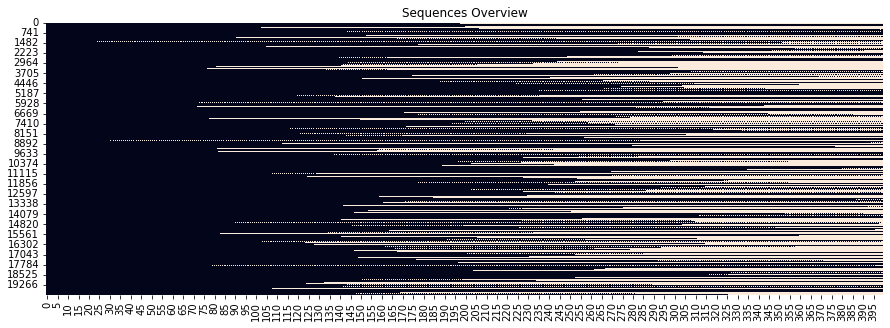

In [ ]:
# Create X_train for seq2seq (sequences of tokens)
dic_seq = text2seq(corpus=dtf_train["text_clean"], top=X_top_words, maxlen=X_len)

X_train, X_tokenizer, X_dic_vocabulary = dic_seq["X"], dic_seq["tokenizer"], dic_seq["dic_vocabulary"]

In [ ]:
dict(list(X_dic_vocabulary.items())[0:6])

{'<PAD>': 0, 'one': 1, 'people': 2, 'time': 5, 'would': 4, 'year': 3}

--- tokenization ---
--- padding to sequence ---
2 sequences of length 400


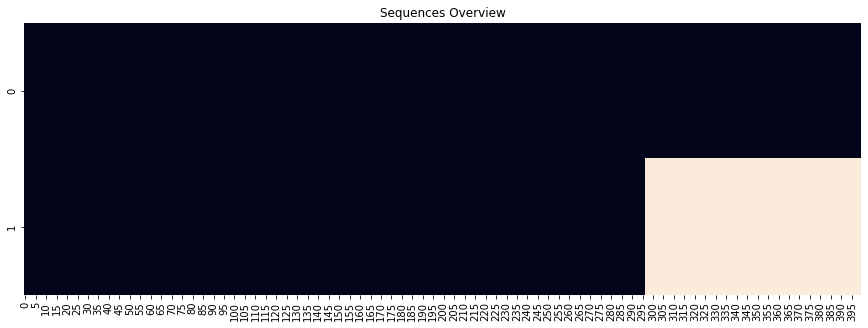

In [ ]:
# Preprocess X_test with the same tokenizer
X_test = text2seq(corpus=dtf_test["text_clean"], fitted_tokenizer=X_tokenizer, maxlen=X_train.shape[1])

In [ ]:
# Add START and END tokens to the summaries (y)
special_tokens = ("<START>", "<END>")
dtf_train["y_clean"] = dtf_train['y_clean'].apply(lambda x: special_tokens[0]+' '+x+' '+special_tokens[1])
dtf_test["y_clean"] = dtf_test['y_clean'].apply(lambda x: special_tokens[0]+' '+x+' '+special_tokens[1])
dtf_test["y_clean"][i]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'<START> usain bolt win third gold world championship anchor jamaica 4x100m relay victory eighth gold championship bolt jamaica double woman 4x100m relay <END>'

--- tokenization ---
10247 words
--- padding to sequence ---
19998 sequences of length 40


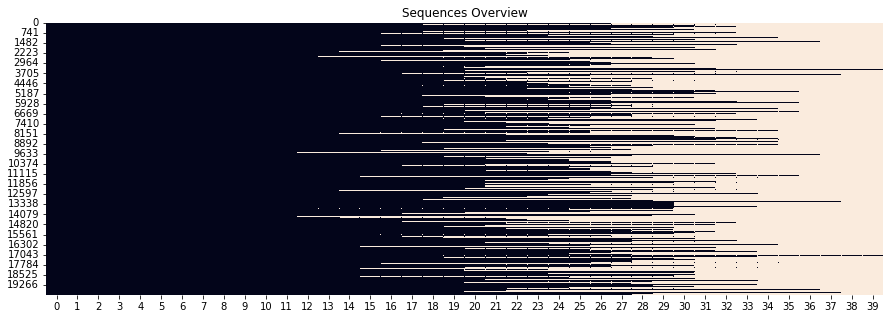

In [ ]:
# Tokenize the summaries (y_train)
dic_seq = text2seq(corpus=dtf_train["y_clean"], top=y_top_words, maxlen=y_len)

y_train, y_tokenizer, y_dic_vocabulary = dic_seq["X"], dic_seq["tokenizer"], dic_seq["dic_vocabulary"]

In [ ]:
dict(list(y_dic_vocabulary.items())[0:6])

{'<END>': 2, '<PAD>': 0, '<START>': 1, 'one': 5, 'people': 4, 'year': 3}

--- tokenization ---
--- padding to sequence ---
2 sequences of length 40


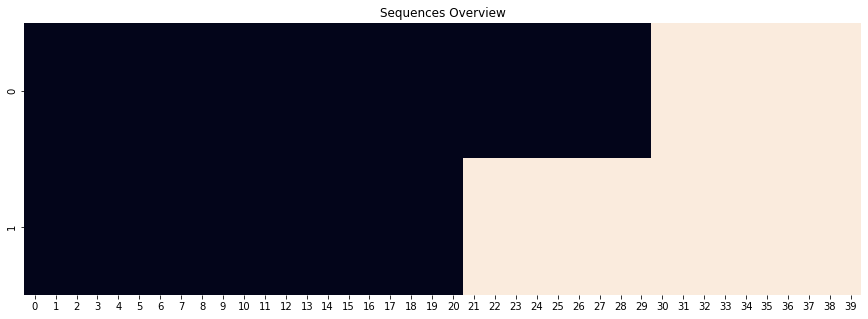

In [ ]:
# Preprocess y_test with the same tokenizer
y_test = text2seq(corpus=dtf_test["y_clean"], fitted_tokenizer=y_tokenizer, maxlen=y_train.shape[1])

###### Create Embedding Weights

In [ ]:
# Load pre-trained Word2Vec
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [ ]:
# Or if we want to train Word2Vec from scratch
# corpus =  dtf_train["text_clean"].append(dtf_train["y_clean"])
# lst_corpus, nlp = fit_w2v(corpus=corpus, min_count=1, size=300, window=y_avg_len)

In [ ]:
X_embeddings = vocabulary_embeddings(X_dic_vocabulary, nlp)
X_embeddings.shape

vocabulary mapped to 43004 vectors of size 300


(43004, 300)

In [ ]:
y_embeddings = vocabulary_embeddings(y_dic_vocabulary, nlp)
y_embeddings.shape

vocabulary mapped to 10248 vectors of size 300


(10248, 300)

###### Model Design

In [ ]:
# Basic Seq2Seq
lstm_units = 250
embeddings_size = 300

##------------ ENCODER (embeddings + lstm) -----------------------------##
x_in = layers.Input(name="x_in", shape=(X_train.shape[1],))
### embedding
layer_x_emb = layers.Embedding(name="x_emb", input_dim=len(X_dic_vocabulary), output_dim=embeddings_size, 
                               trainable=True)
x_emb = layer_x_emb(x_in)
### lstm 
layer_x_lstm = layers.LSTM(name="x_lstm", units=lstm_units, dropout=0.4,  
                           return_sequences=True, return_state=True)
x_out, state_h, state_c = layer_x_lstm(x_emb)

##------------ DECODER (embeddings + lstm + dense) ---------------------##
y_in = layers.Input(name="y_in", shape=(None,))
### embedding
layer_y_emb = layers.Embedding(name="y_emb", input_dim=len(y_dic_vocabulary), output_dim=embeddings_size, 
                               trainable=True)
y_emb = layer_y_emb(y_in)
### lstm 
layer_y_lstm = layers.LSTM(name="y_lstm", units=lstm_units, dropout=0.4,
                           return_sequences=True, return_state=True)
y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])
### final dense layers
layer_dense = layers.TimeDistributed(name="dense", 
                                     layer=layers.Dense(units=len(y_dic_vocabulary), activation='softmax'))
y_out = layer_dense(y_out)

##---------------------------- COMPILE --------------------------------##
model = models.Model(inputs=[x_in, y_in], outputs=y_out, name="Seq2Seq")
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "Seq2Seq"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_in (InputLayer)              [(None, 400)]        0           []                               
                                                                                                  
 y_in (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 x_emb (Embedding)              (None, 400, 300)     12900900    ['x_in[0][0]']                   
                                                                                                  
 y_emb (Embedding)              (None, None, 300)    3074100     ['y_in[0][0]']                   
                                                                                            

###### Train

Epoch 1/10
219/219 [==============================] - 58s 106ms/step - loss: 5.4338 - accuracy: 0.3698 - val_loss: 5.2598 - val_accuracy: 0.3760
Epoch 2/10
219/219 [==============================] - 23s 103ms/step - loss: 5.1688 - accuracy: 0.3805 - val_loss: 5.1797 - val_accuracy: 0.3781
Epoch 3/10
219/219 [==============================] - 23s 105ms/step - loss: 5.0717 - accuracy: 0.3831 - val_loss: 5.1117 - val_accuracy: 0.3805
Epoch 4/10
219/219 [==============================] - 23s 106ms/step - loss: 4.9843 - accuracy: 0.3861 - val_loss: 5.0490 - val_accuracy: 0.3824
Epoch 5/10
219/219 [==============================] - 23s 106ms/step - loss: 4.8870 - accuracy: 0.3887 - val_loss: 4.9747 - val_accuracy: 0.3844
Epoch 6/10
219/219 [==============================] - 23s 107ms/step - loss: 4.7984 - accuracy: 0.3912 - val_loss: 4.9290 - val_accuracy: 0.3867
Epoch 7/10
219/219 [==============================] - 24s 108ms/step - loss: 4.7170 - accuracy: 0.3939 - val_loss: 4.8881 - val_ac

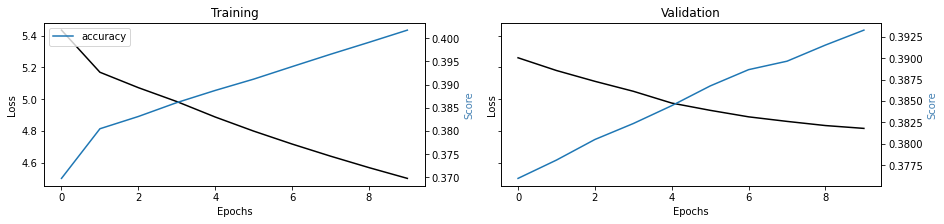

In [ ]:
# This takes a while
model = fit_seq2seq(X_train, y_train, model, build_encoder_decoder=False, 
                    epochs=10, batch_size=64, verbose=1)
#model, encoder_model, decoder_model = fit_seq2seq(X_train, y_train, X_embeddings, y_embeddings, model, 
#                                                  build_encoder_decoder=True, epochs=100, batch_size=64)

###### Test

In [ ]:
# Prediction Encoder
encoder_model = models.Model(inputs=x_in, outputs=[x_out, state_h, state_c], name="Prediction_Encoder")
encoder_model.summary()

Model: "Prediction_Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_in (InputLayer)           [(None, 400)]             0         
                                                                 
 x_emb (Embedding)           (None, 400, 300)          12900900  
                                                                 
 x_lstm (LSTM)               [(None, 400, 250),        551000    
                              (None, 250),                       
                              (None, 250)]                       
                                                                 
Total params: 13,451,900
Trainable params: 13,451,900
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Prediction Decoder
## Double the lstm units if you used bidirectional lstm
lstm_units = lstm_units*2 if any("Bidirectional" in str(layer) for layer in model.layers) else lstm_units

## States of the previous time step
x_out2 = layers.Input(shape=(X_train.shape[1], lstm_units))
state_h, state_c = layers.Input(shape=(lstm_units,)), layers.Input(shape=(lstm_units,))

## Decoder embeddings
y_emb2 = layer_y_emb(y_in)

## Lstm to predict the next word
y_out2, new_state_h, new_state_c = layer_y_lstm(y_emb2, initial_state=[state_h, state_c])

## Softmax to generate probability distribution over the target vocabulary
probs = layer_dense(y_out2)

## Compile
decoder_model = models.Model(inputs=[y_in, x_out2, state_h, state_c], 
                             outputs=[probs, new_state_h, new_state_c],
                             name="Prediction_Decoder")
decoder_model.summary()

Model: "Prediction_Decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 y_in (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 y_emb (Embedding)              (None, None, 300)    3074100     ['y_in[0][0]']                   
                                                                                                  
 input_2 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 250)]        0           []                               
                                                                                 

In [ ]:
predicted = predict_seq2seq(X_test, encoder_model, decoder_model, y_tokenizer, special_tokens)

In [ ]:
# Evaluate
evaluate_summary(dtf_test["y_clean"][i], predicted[i])

rouge1: 0.1 | rouge2: 0.04 | rougeL: 0.04 --> avg rouge: 0.08


In [ ]:
score = 0.0
for i in range(dtf_test["y"].size):
  score += evaluate_summary(dtf_test["y"][i], predicted[i])
print("Overall Average Rouge score over tests ",round(score/dtf_test["y"].size,5))

In [ ]:
# Compare y_test and predicted
match = display_string_matching(dtf_test["y_clean"][i], predicted[i], both=True, sentences=False, 
                                titles=["Real Summary", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))

In [ ]:
# Explainability
match = display_string_matching(dtf_test["text_clean"][i], predicted[i], both=True, sentences=False, 
                                titles=["Full Text", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))

### 5 - Model (Abstractive: Language model)

In [1]:
import transformers

In [17]:
# Test (no Train)
predicted = bart(corpus=dtf_test["text"],max_len=y_len)

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [38]:
score = 0.0
for i in range(dtf_test["y"].size):
  score += evaluate_summary(dtf_test["y"][i], predicted[i])
print("Overall Average Rouge score over tests ",round(score/dtf_test["y"].size,5))

Overall Average Rouge score over tests  0.286


In [26]:
# Evaluate
evaluate_summary(dtf_test["y"][i], predicted[i])

rouge1: 0.14 | rouge2: 0.0 | rougeL: 0.0 --> avg rouge: 0.09
None


In [18]:
# Compare y_test and predicted
match = display_string_matching(dtf_test["y"][i], predicted[i], both=True, sentences=False, 
                                titles=["Real Summary", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))

In [19]:
# Explainability
match = display_string_matching(dtf_test["text"][i], predicted[i], both=True, sentences=True, 
                                titles=["Full Text", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))